In [1]:
!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar -xf ucf101_top5.tar.gz

In [1]:
import os
import keras
from keras import layers
from keras.applications.densenet import DenseNet121

from tensorflow_docs.vis import embed

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2

2025-10-30 12:25:22.947361: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = keras.ops.convert_to_numpy(cropped)
    cropped = keras.ops.squeeze(cropped)
    return cropped


# Following method is modified from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def load_video(path, max_frames=0, offload_to_cpu=False):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = frame[:, :, [2, 1, 0]]
            frame = crop_center(frame)
            if offload_to_cpu and keras.backend.backend() == "torch":
                frame = frame.to("cpu")
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    if offload_to_cpu and keras.backend.backend() == "torch":
        return np.array([frame.to("cpu").numpy() for frame in frames])
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

Total videos for training: 594
Total videos for testing: 224


I0000 00:00:1761823534.334060  660177 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8682 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


[np.str_('CricketShot'), np.str_('PlayingCello'), np.str_('Punch'), np.str_('ShavingBeard'), np.str_('TennisSwing')]


In [6]:
!!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!!tar -xf top5_data_prepared.tar.gz

[]

In [4]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [5]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def build(self, input_shape):
        self.position_embeddings.build(input_shape)

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        inputs = keras.ops.cast(inputs, self.compute_dtype)
        length = keras.ops.shape(inputs)[1]
        positions = keras.ops.arange(start=0, stop=length, step=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

In [6]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation=keras.activations.gelu),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [7]:
def get_compiled_model(shape):
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=shape)
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


def run_experiment():
    filepath = "/tmp/video_classifier.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model(train_data.shape[1:])
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [8]:
trained_model = run_experiment()

Epoch 1/5


2025-10-30 12:25:47.339211: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e2cd40018b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 12:25:47.339226: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-10-30 12:25:47.382191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 12:25:47.636344: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300


10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3134 - loss: 4.1241

I0000 00:00:1761823549.463037  660274 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4029 - loss: 3.4671
Epoch 1: val_loss improved from None to 1.89074, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.6052 - loss: 2.0465 - val_accuracy: 0.1333 - val_loss: 1.8907
Epoch 2/5
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9395 - loss: 0.2046 
Epoch 2: val_loss improved from 1.89074 to 0.48499, saving model to /tmp/video_classifier.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9425 - loss: 0.1684 - val_accuracy: 0.7778 - val_loss: 0.4850
Epoch 3/5
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0150 
Epoch 3: val_loss did not improve from 0.48499
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.5444 - val_loss: 1.7773
Epoch 4/5
10/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0099     
Epoch 4: val_loss did not improve from 0.48499
16/16 ━━━━━━━━━━━━━━━━━━━━ 0

Test video path: v_TennisSwing_g02_c01.avi
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
  Punch: 98.40%
  TennisSwing:  1.37%
  CricketShot:  0.23%
  PlayingCello:  0.01%
  ShavingBeard:  0.00%


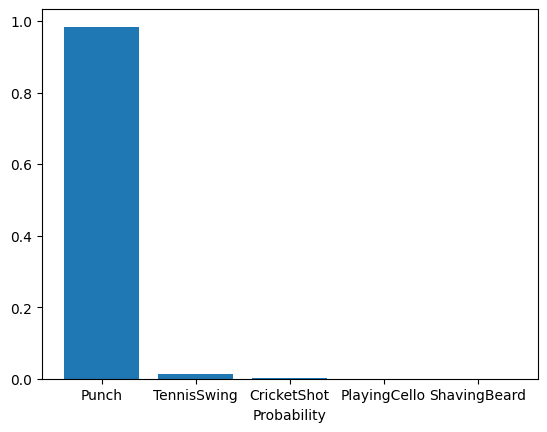


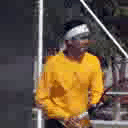

In [9]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path), offload_to_cpu=True)
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    plot_x_axis, plot_y_axis = [], []

    for i in np.argsort(probabilities)[::-1]:
        plot_x_axis.append(class_vocab[i])
        plot_y_axis.append(probabilities[i])
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    plt.bar(plot_x_axis, plot_y_axis, label=plot_x_axis)
    plt.xlabel("class_label")
    plt.xlabel("Probability")
    plt.show()

    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])